In [ ]:
#Importam librarie
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
data = files.upload()#incarcarea datelor

Saving AirPassengers.csv to AirPassengers.csv


In [ ]:
import io#citirea a datelor
df = pd.read_csv(io.BytesIO(data['AirPassengers.csv']))
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df.isnull().sum()#Verificam  dacă există valori nule în setul nostru de date.

Month          0
#Passengers    0
dtype: int64

In [ ]:
df.info()##Obținem detalii generale ale setului nostru de date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


De sus putem vedea că tipul de date din coloana „Month” este „obiect”. Pentru a continua cu analiza serii de timp, trebuie să o facem ca format de data

In [ ]:
df['Month']=pd.to_datetime(df['Month'])

In [ ]:
#De asemenea, coloana de pasageri este în format int. Dar pentru calcul / predicție obținem în mare parte float dtype. Deci, actualizam dtype.
df['#Passengers']=df['#Passengers'].astype('float64')

In [ ]:
df.info()##După conversia dtype, să obținem acum detaliile generale ale setului de date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


Din nou pentru a lucra în analiza serii de timp, putem face coloana lunii în indexul setului de date

In [ ]:
df.set_index('Month',inplace=True)

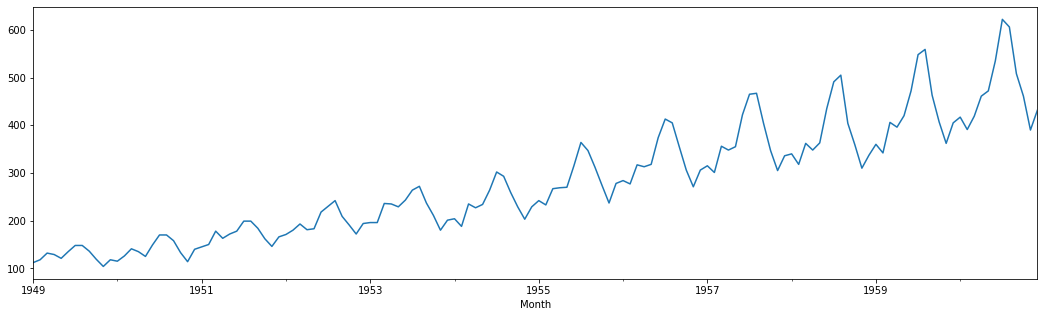

In [ ]:
df['#Passengers'].plot(figsize=(18,5))# O sa vedem date nostru in graf representat

De sus putem vedea clar că datele noastre au o sezonalitate de 12 luni.

Înainte de a merge pentru analiza serii de timp, ar trebui să verificăm staționaritatea datelor.
Aici folosim testul Augmented Dicky-Fuller (ADF) și conceptul de ipoteză nulă pentru staționaritatea datelor
Crearea unei funcții pentru a utiliza acest test în mod frecvent

In [ ]:
def fullertest(series):
    result=adfuller(series)
    pvalue = result[1]
    if pvalue > .05:
        print('Avem dovezi grozave în care nu putem respinge ipoteza nulă și spunem că datele nu sunt staționare')
    else:
        print('Avem dovezi grozave în care nu putem respinge ipoteza nulă și spunem că datele sunt staționare')
    

In [ ]:
#Acum putem sa folosim functia de mai sus pentru datele nostru
fullertest(df['#Passengers'])

Avem dovezi grozave în care nu putem respinge ipoteza nulă și spunem că datele nu sunt staționare


De sus putem vedea că setul nostru de date nu este date staționare. Să folosim conceptul „Diferențiare” pentru a-l face staționar
Shifting 1 rând și găsim diferența

Month
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Name: 1 Shifted Passengers, dtype: float64
Avem dovezi grozave în care nu putem respinge ipoteza nulă și spunem că datele nu sunt staționare


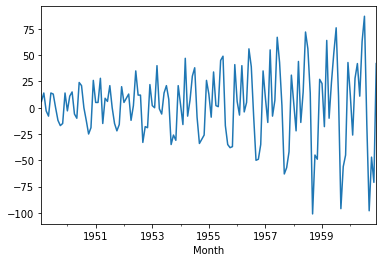

In [ ]:
df['1 Shifted Passengers'] = df['#Passengers'] - df['#Passengers'].shift(1)
print(df['1 Shifted Passengers'].head())
df = df.dropna()
df['1 Shifted Passengers'].plot()
fullertest(df['1 Shifted Passengers'])


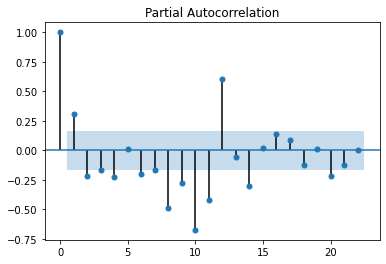

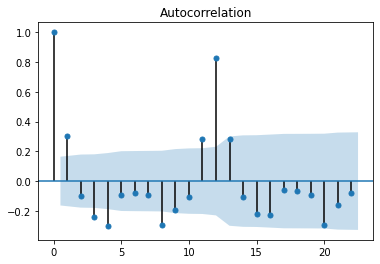

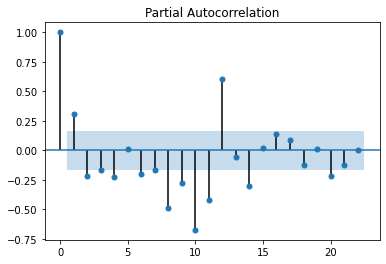

In [ ]:
#Graficul ACF și PACF pentru datele de mai sus
plot_acf(df['1 Shifted Passengers'])
plot_pacf(df['1 Shifted Passengers'])

Month
1949-02-01     NaN
1949-03-01     NaN
1949-04-01    11.0
1949-05-01   -11.0
1949-06-01     6.0
Name: 2 Shifted Passengers, dtype: float64
Avem dovezi grozave în care nu putem respinge ipoteza nulă și spunem că datele sunt staționare


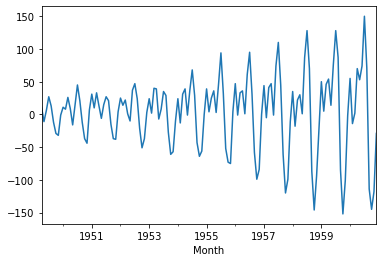

In [ ]:
#Schimbând 2 rânduri și găsim diferența
df['2 Shifted Passengers'] = df['#Passengers'] - df['#Passengers'].shift(2)
print(df['2 Shifted Passengers'].head())
df = df.dropna()
df['2 Shifted Passengers'].plot()
fullertest(df['2 Shifted Passengers'])

Month
1949-04-01   NaN
1949-05-01   NaN
1949-06-01   NaN
1949-07-01   NaN
1949-08-01   NaN
Name: 12 Shifted Passengers, dtype: float64
Avem dovezi grozave în care nu putem respinge ipoteza nulă și spunem că datele sunt staționare


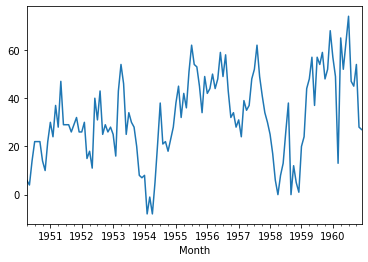

In [ ]:
df['12 Shifted Passengers'] = df['#Passengers'] - df['#Passengers'].shift(12)
print(df['12 Shifted Passengers'].head())
df = df.dropna()
df['12 Shifted Passengers'].plot()
fullertest(df['12 Shifted Passengers'])

Graficul ACF și PACF pentru datele de mai sus

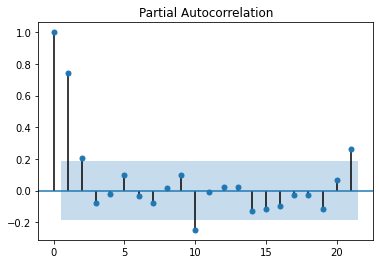

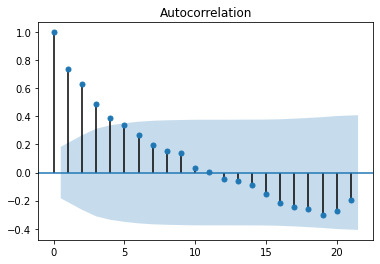

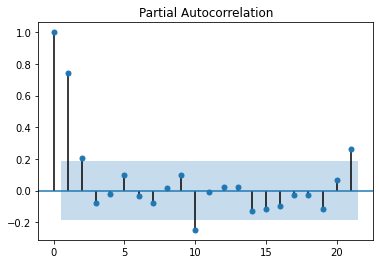

In [ ]:
plot_acf(df['12 Shifted Passengers'])
plot_pacf(df['12 Shifted Passengers'])

De sus putem vedea că avem o dată staționară. Dar, după cum sa văzut deja, datele noastre au o sezonalitate de 12 date, să verificăm cu schimbarea de 12 luni.

Month
1950-06-01   NaN
1950-07-01   NaN
1950-08-01   NaN
1950-09-01   NaN
1950-10-01   NaN
Name: 12 Shifted Passengers, dtype: float64
Avem dovezi grozave în care nu putem respinge ipoteza nulă și spunem că datele sunt staționare


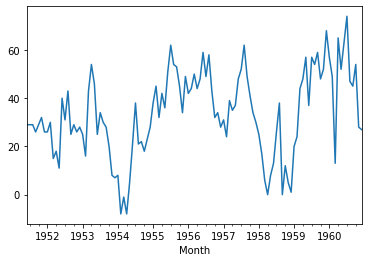

In [ ]:
#Schimbând 12 rânduri și găsim diferența
df['12 Shifted Passengers'] = df['#Passengers'] - df['#Passengers'].shift(12)
print(df['12 Shifted Passengers'].head())
df = df.dropna()
df['12 Shifted Passengers'].plot()
fullertest(df['12 Shifted Passengers'])

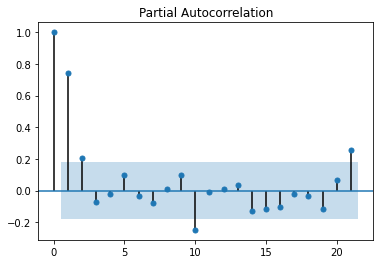

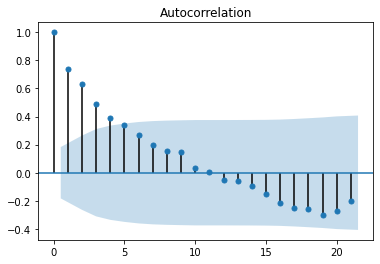

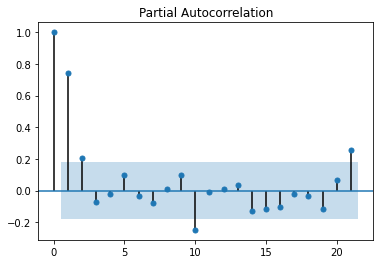

In [ ]:
#Graficul ACF și PACF pentru datele de mai sus
plot_acf(df['12 Shifted Passengers'])
plot_pacf(df['12 Shifted Passengers'])

Acum este timpul să creăm modelul.
 Cream mai întâi train_data si test_data

In [ ]:
train_dataset_end=datetime(1955,12,1)
test_dataset_end=datetime(1960,12,1)
train_data=df[:train_dataset_end]
test_data=df[train_dataset_end+timedelta(days=1):test_dataset_end]

In [ ]:
#model ARIMA
model_ARIMA=sm.tsa.arima.ARIMA(train_data['#Passengers'],order=(0,2,0))
model_Arima_fit=model_ARIMA.fit()
model_Arima_fit.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                   55
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -255.623
Date:                Tue, 17 Jan 2023   AIC                            513.247
Time:                        08:55:06   BIC                            515.217
Sample:                    06-01-1951   HQIC                           514.004
                         - 12-01-1955                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       905.2740    176.214      5.137      0.000     559.901    1250.647
===================================================================================
Ljung-Box (L1) (Q):                   2.46   Jarque-Bera (JB):                 0.79
Prob(Q):                              0.12   Prob(JB):                         0.67
Heteroskedasticity (H):               2.41   Skew:                             0.30
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Pentru predictii
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

1956-01-01 00:00:00
1960-12-01 00:00:00


In [ ]:
#Facem predictii de date de la model caream creat
pred=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [ ]:
#Crearea unei coloane și păstrarea datelor noastre prezise pentru a le evalua cu ușurință
test_data['Pred']=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
test_data.head(10)

<ipython-input-28-288a9c2a802c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Pred']=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)


,#Passengers,1 Shifted Passengers,2 Shifted Passengers,12 Shifted Passengers,Pred
Month,,,,,
1956-01-01,284.0,6.0,47.0,42.0,319.0
1956-02-01,277.0,-7.0,-1.0,44.0,360.0
1956-03-01,317.0,40.0,33.0,50.0,401.0
1956-04-01,313.0,-4.0,36.0,44.0,442.0
1956-05-01,318.0,5.0,1.0,48.0,483.0
1956-06-01,374.0,56.0,61.0,59.0,524.0
1956-07-01,413.0,39.0,95.0,49.0,565.0
1956-08-01,405.0,-8.0,31.0,58.0,606.0
1956-09-01,355.0,-50.0,-58.0,43.0,647.0


Să găsim reziduurile pentru a vedea eroarea în modelul nostru

In [ ]:
residuals=test_data['#Passengers']-pred
residuals

Month
1956-01-01     -35.0
1956-02-01     -83.0
1956-03-01     -84.0
1956-04-01    -129.0
1956-05-01    -165.0
1956-06-01    -150.0
1956-07-01    -152.0
1956-08-01    -201.0
1956-09-01    -292.0
1956-10-01    -382.0
1956-11-01    -458.0
1956-12-01    -464.0
1957-01-01    -496.0
1957-02-01    -551.0
1957-03-01    -537.0
1957-04-01    -586.0
1957-05-01    -620.0
1957-06-01    -594.0
1957-07-01    -592.0
1957-08-01    -631.0
1957-09-01    -735.0
1957-10-01    -833.0
1957-11-01    -916.0
1957-12-01    -926.0
1958-01-01    -963.0
1958-02-01   -1026.0
1958-03-01   -1023.0
1958-04-01   -1078.0
1958-05-01   -1104.0
1958-06-01   -1073.0
1958-07-01   -1058.0
1958-08-01   -1085.0
1958-09-01   -1227.0
1958-10-01   -1313.0
1958-11-01   -1403.0
1958-12-01   -1417.0
1959-01-01   -1435.0
1959-02-01   -1494.0
1959-03-01   -1471.0
1959-04-01   -1522.0
1959-05-01   -1539.0
1959-06-01   -1528.0
1959-07-01   -1493.0
1959-08-01   -1523.0
1959-09-01   -1660.0
1959-10-01   -1757.0
1959-11-01   -1843.0
1959-12